# Classifying images of cats and dogs

This project uses DenseNet model to differentiate between images of cats and dogs.

DenseNet consists of the features and the classifier. The features part is a stack of convolutional layers and works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer (`classifier`): `Linear(in_features=1024, out_features=1000)`. Classifier was trained on a different dataset, so it won't work for this project. It means that we will replace the classifier, but the features will work on their own.

We use CUDA to efficiently compute the forward and backwards passes on the GPU.

In [1]:
import torch
from torchvision import datasets, transforms, models
import numpy as np
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 64
# 10% of training set will be used for validation purposes
valid_size = 0.1
# number of subprocesses to use for data loading
num_workers = 0

# Define a transform for trainset to normalize the data
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Download the data
trainset = datasets.ImageFolder('~/.pytorch/Cat_Dog_data/train', transform=train_transform)
testset = datasets.ImageFolder('~/.pytorch/Cat_Dog_data/test', transform=test_transform)

# obtain validation indices
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
sampler=train_sampler, num_workers=num_workers)

validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
sampler=valid_sampler, num_workers=num_workers)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
shuffle=True, num_workers=num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


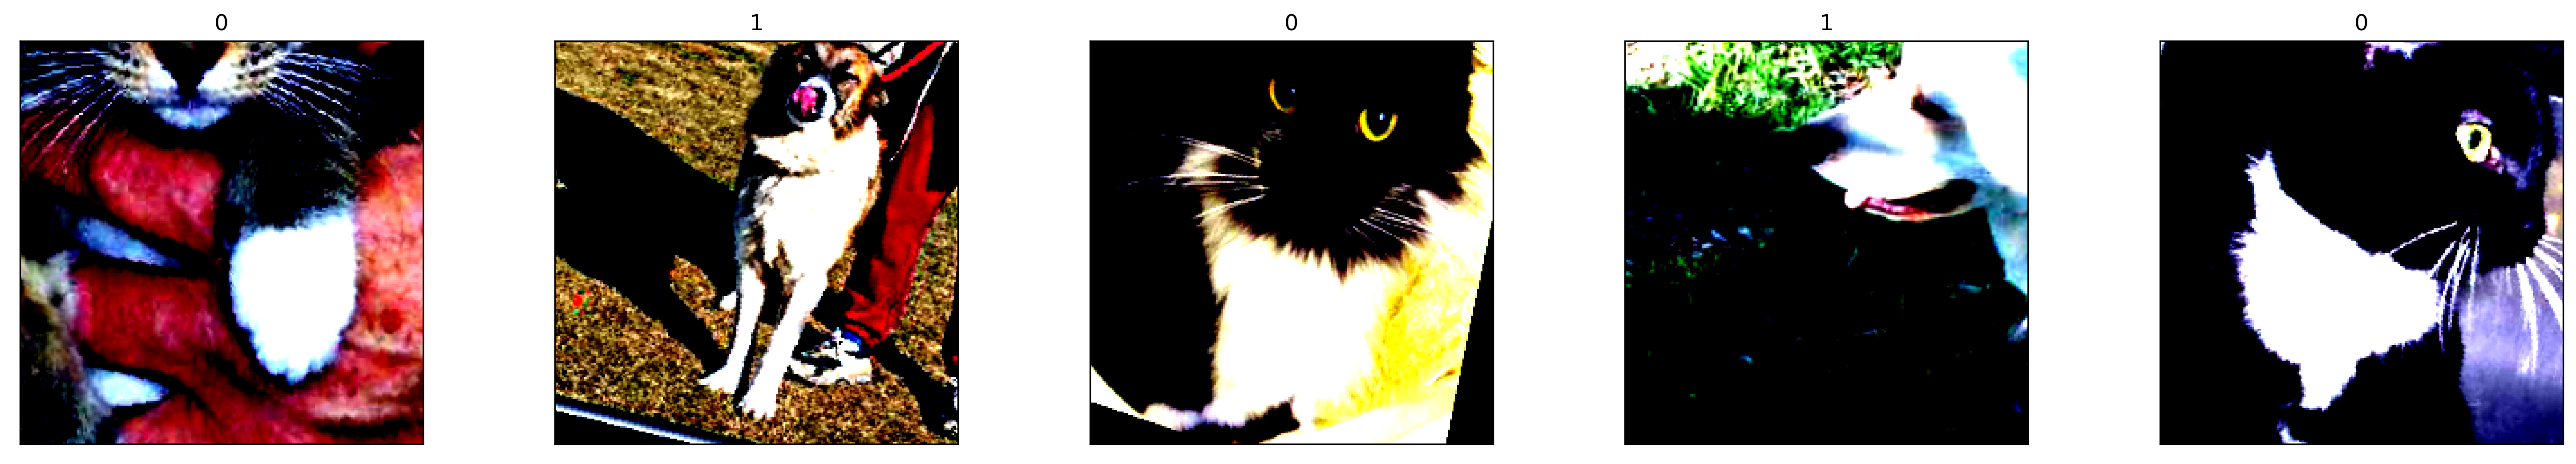

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4), dpi=300)
for i in np.arange(5):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    index = np.random.randint(0,63)
    ax.imshow(images[index].permute(1,2,0))

    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[index].item()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])


<Figure size 432x288 with 0 Axes>

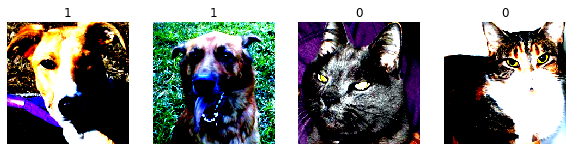

In [4]:
#Helper method for image display
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    index = np.random.randint(0,63)
    ax = axes[ii]
    imshow(images[index], ax=ax, normalize=False)
    ax.set_title(str(labels[index].item()))
    
print(images.shape)

In [5]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

#Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.pequires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.parameters(), lr=0.003)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [6]:
epochs = 1
steps = 0
train_accuracy = 0
print_every = 5
valid_loss = 0
train_loss = 0

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial value to infinity

model.train() # prep model for training

for e in range(epochs):
    for images, labels in trainloader:
        steps += 1
        
        #Move input and label tensors to the GPU
        images, labels = images.to(device), labels.to(device)
        
        ###############
        #Training pass#
        ###############
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        logits = model.forward(images)
        
        loss = criterion(logits, labels)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
        
        #Calculate accuracy
        ps = torch.exp(logits)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        ############
        #Validating#
        ############
        
        # Turn off gradients for testing, saves memory and computations
        with torch.no_grad():
            for images, labels in validloader:
                #Move input and label tensors to the GPU
                images, labels = images.to(device), labels.to(device)
                # Forward pass
                output = model.forward(images)
                # Calculate the loss
                loss = criterion(output, labels)
                # Update running validation loss
                valid_loss += loss.item()*images.size(0)
        
        # Calculate average loss
        train_loss = train_loss/len(trainloader.sampler)
        valid_loss = valid_loss/len(validloader.dataset)

        if steps % print_every == 0:
            print(f'Step: {steps}, ',
            f"Training loss: {train_loss:.3f}, ",
            f'Training Accuracy: {train_accuracy*100/len(trainloader):.2f}%, ',
            f'Validation Loss: {valid_loss:.3f} ')
            
        # Save model if validation loss has decreaed
        if valid_loss <= valid_loss_min:
                print('Step {}. Validation loss decreased ({:.6f} --> {:.6f}). Saving model.'.format(
                steps,
                valid_loss_min,
                valid_loss))
                torch.save(model.state_dict(), 'cat_dog.pt')
                valid_loss_min = valid_loss 

Step 1. Validation loss decreased (inf --> 0.144534). Saving model.
Step 2. Validation loss decreased (0.144534 --> 0.070241). Saving model.
Step: 5,  Training loss: 0.003,  Training Accuracy: 0.96%,  Validation Loss: 0.084 
Step 6. Validation loss decreased (0.070241 --> 0.068109). Saving model.
Step 8. Validation loss decreased (0.068109 --> 0.067183). Saving model.
Step 9. Validation loss decreased (0.067183 --> 0.066688). Saving model.
Step: 10,  Training loss: 0.002,  Training Accuracy: 2.05%,  Validation Loss: 0.068 
Step 13. Validation loss decreased (0.066688 --> 0.064371). Saving model.
Step: 15,  Training loss: 0.002,  Training Accuracy: 2.94%,  Validation Loss: 0.067 
Step: 20,  Training loss: 0.002,  Training Accuracy: 3.80%,  Validation Loss: 0.067 
Step: 25,  Training loss: 0.002,  Training Accuracy: 4.73%,  Validation Loss: 0.068 
Step: 30,  Training loss: 0.002,  Training Accuracy: 5.59%,  Validation Loss: 0.067 
Step: 35,  Training loss: 0.002,  Training Accuracy: 6.52

In [7]:
# Load the model with the lowest validation loss
model.load_state_dict(torch.load('cat_dog.pt'))

<All keys matched successfully>

In [8]:
#########
#Testing#
#########
test_loss = 0
class_correct = list(0. for i in range(batch_size))
class_total = list(0. for i in range(batch_size))
accuracy = 0

# Inference mode, turns off dropout
model.eval()

# Turn off gradients for testing, saves memory and computations
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        logits = model.forward(images)
        batch_loss = criterion(logits, labels)
        test_loss += batch_loss.item()*images.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(logits, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
        
        #Calculate accuracy
        ps = torch.exp(logits)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # calculate test accuracy for each object class
        for i in range(len(labels)):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
#Calculate and print avg test loss
test_loss = test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
print(f'Test Accuracy (old method): {accuracy*100/len(testloader):.2f}%')

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.499261

Test Accuracy (old method): 75.66%
Test Accuracy of     0: 75% (940/1250)
Test Accuracy of     1: 76% (952/1250)

Test Accuracy (Overall): 75% (1892/2500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

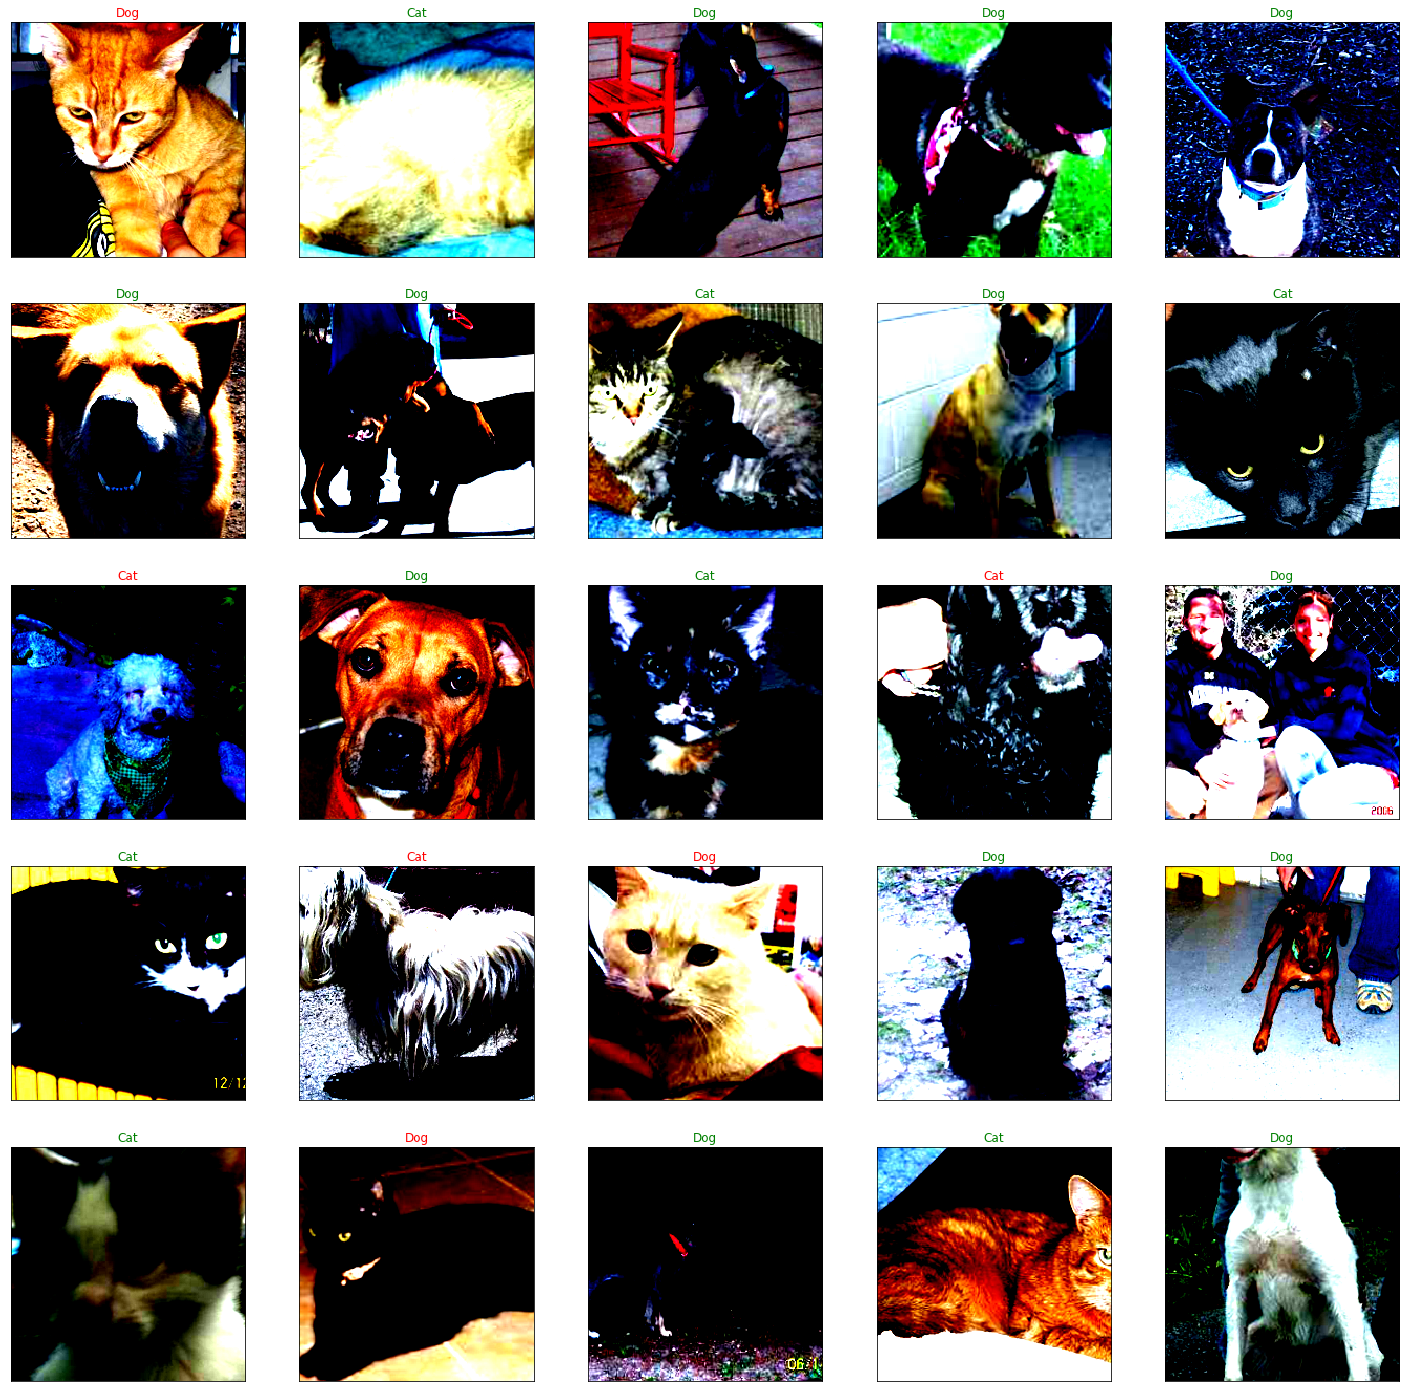

In [9]:
import random

# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    # get sample outputs
    output = model.forward(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 25))

indices = random.sample(range(64), 25)

for idx in np.arange(25):
    index = indices[idx]
    predicate = preds[index]
    label = labels[index]
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(np.transpose(images[index], (1, 2, 0))))
    ax.set_title("{}".format('Cat' if str(predicate.item()) == '0' else 'Dog'), 
        color=("green" if predicate==label else "red"))

In [ ]:
# delete model in case we want to redo the training
del model